In [9]:
import sqlite3
DATABASE_FILE = "power_data2.db"  
ROW_LIMIT = 5                     

def analyze_sqlite_db(db_file):
    """Connects to the SQLite DB, lists all tables, and prints data samples."""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        cursor = conn.cursor()
        print(f"✅ Successfully connected to: **{db_file}**\n")
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = [table[0] for table in cursor.fetchall()]
        if not tables:
            print("❌ No tables found in the database.")
            return
        print(f"✨ Found **{len(tables)}** tables: {', '.join(tables)}\n")
        for table_name in tables:
            print("---" * 15)
            print(f"🚀 Analyzing Table: **{table_name}**")
            cursor.execute(f"PRAGMA table_info({table_name});")
            columns_info = [f"{col[1]} ({col[2]})" for col in cursor.fetchall()]
            print(f"   Schema (Column Name & Type): {', '.join(columns_info)}")
            cursor.execute(f"SELECT * FROM {table_name} LIMIT {ROW_LIMIT};")
            rows = cursor.fetchall()
            if rows:
                headers = [description[0] for description in cursor.description]
                print(f"   Sample Data (First {ROW_LIMIT} rows):")
                print(f"   {' | '.join(headers)}")
                print(f"   {'-' * (len(' | '.join(headers)) + 5)}")
                for row in rows:
                    print(f"   {' | '.join(map(str, row))}")
            else:
                print("   (Table is empty)")

    except sqlite3.Error as e:
        print(f"An SQLite error occurred: {e}")
    finally:
        if conn:
            conn.close()
            print("\nConnection closed.")

if __name__ == '__main__':
    analyze_sqlite_db(DATABASE_FILE)

✅ Successfully connected to: **power_data2.db**

✨ Found **3** tables: power_data, sqlite_sequence, power_events

---------------------------------------------
🚀 Analyzing Table: **power_data**
   Schema (Column Name & Type): id (INTEGER), phase (TEXT), voltage_rms (REAL), current_rms (REAL), active_power (REAL), reactive_power (REAL), apparent_power (REAL), energy_kwh (REAL), voltage_thd (REAL), current_thd (REAL), power_factor (REAL), voltage_freq (REAL), timestamp (TEXT), sync (BOOLEAN)
   Sample Data (First 5 rows):
   id | phase | voltage_rms | current_rms | active_power | reactive_power | apparent_power | energy_kwh | voltage_thd | current_thd | power_factor | voltage_freq | timestamp | sync
   --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
   41067882 | Neutral | 0.0 | 0.06709506147 | None | None | None | 0.0 | None | None | None | None | 2025-1

In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

DATABASE_FILE = "power_data2.db"

def plot_voltage_over_time(db_file):
    """
    Connects to the database, fetches voltage data, and plots it over time.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        
        # SQL Query to fetch timestamp, phase, and RMS voltage for the main phases
        query = """
        SELECT timestamp, phase, voltage_rms
        FROM power_data
        WHERE phase IN ('R', 'Y', 'B') AND voltage_rms IS NOT NULL AND voltage_rms > 0
        ORDER BY timestamp;
        """

        df = pd.read_sql_query(query, conn)
        
        # Convert the 'timestamp' column (TEXT) to datetime objects
        df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

        # Plotting the data
        plt.figure(figsize=(14, 7))

        phases = df['phase'].unique()
        # Custom colors for R (Red), Y (Yellow/Orange), B (Blue)
        phase_colors = {'R': 'red', 'Y': 'orange', 'B': 'blue'}

        for phase in phases:
            phase_data = df[df['phase'] == phase]
            plt.plot(
                phase_data['timestamp'],
                phase_data['voltage_rms'],
                label=f'Phase {phase}',
                color=phase_colors.get(phase, 'gray'),
                marker='.',
                linestyle='-',
                markersize=2,
                linewidth=0.5
            )

        plt.title('RMS Voltage Over Time by Phase', fontsize=16)
        plt.xlabel('Timestamp (UTC)', fontsize=12)
        plt.ylabel('Voltage RMS (V)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Phase')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        # Display or save the plot
        plt.show() # Use plt.savefig('voltage_plot.png') to save to a file
        
    except sqlite3.Error as e:
        print(f"An SQLite error occurred: {e}")
    except pd.errors.DatabaseError as e:
        print(f"A Pandas/Database error occurred. Check if the 'power_data' table exists. Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    plot_voltage_over_time(DATABASE_FILE)

KeyboardInterrupt: 

In [8]:
import sqlite3
import pandas as pd

# IMPORTANT: Use the new, clean database file
DATABASE_FILE = "power_data2.db" 
OUTPUT_CSV_FILE = "first_100000_power_data.csv"
TABLE_NAME = "power_data"  # Verify this is the correct table name from the clean database

def extract_and_save_data(db_file, table_name, limit, output_file):
    """Connects to the DB, extracts the first N rows, and saves them to CSV."""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(f"✅ Successfully connected to: **{db_file}**")
        
        # SQL query to get the first N rows (100,000 in this case)
        query = f"""
        SELECT * FROM {table_name}
        LIMIT {limit};
        """
        
        print(f"⏳ Extracting the first {limit:,} data points from table '{table_name}'...")
        
        # Read the query result directly into a Pandas DataFrame
        df = pd.read_sql_query(query, conn)
        
        if df.empty:
            print(f"⚠️ No data found in the table '{table_name}'.")
            return

        # Save the DataFrame to a CSV file
        df.to_csv(output_file, index=False)
        
        print(f"\n✨ Successfully extracted {len(df):,} rows.")
        print(f"💾 Data saved to: **{output_file}**")
        
    except sqlite3.OperationalError as e:
        print(f"❌ SQLite Operational Error: {e}")
        print("   HINT: Check if the database file exists or if the TABLE_NAME is correct.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    ROW_LIMIT = 300000
    extract_and_save_data(DATABASE_FILE, TABLE_NAME, ROW_LIMIT, OUTPUT_CSV_FILE)

✅ Successfully connected to: **power_data2.db**
⏳ Extracting the first 300,000 data points from table 'power_data'...

✨ Successfully extracted 300,000 rows.
💾 Data saved to: **first_100000_power_data.csv**


In [9]:
import pandas as pd

# 1. Define the filename created in the previous step
CSV_FILE_NAME = "first_100000_power_data.csv"

# 2. Read the CSV file into a DataFrame
try:
    df = pd.read_csv(CSV_FILE_NAME)
    
    # 3. Print the first 5 rows (the head)
    print(f"✅ Displaying the head of the '{CSV_FILE_NAME}' file:\n")
    print(df.head())
    
    # Also print summary info for quick verification of data types and non-null counts
    print("\n--- DataFrame Information ---")
    df.info()

except FileNotFoundError:
    print(f"❌ Error: The file '{CSV_FILE_NAME}' was not found. Please ensure it is in the same directory as this script.")
except Exception as e:
    print(f"An error occurred while reading the CSV: {e}")

✅ Displaying the head of the 'first_100000_power_data.csv' file:

         id    phase  voltage_rms  current_rms  active_power  reactive_power  \
0  41067882  Neutral     0.000000     0.067095           NaN             NaN   
1  41067883        R   227.159104     0.037584      1.591817       -7.371628   
2  41067884        Y   230.218599     0.000000      0.004738       -0.014213   
3  41067885        B   225.521043     0.000000      0.014213        0.052113   
4  41067886  Neutral     0.000000     0.067098           NaN             NaN   

   apparent_power  energy_kwh  voltage_thd  current_thd  power_factor  \
0             NaN    0.000000          NaN          NaN           NaN   
1        8.532328   74.895449     2.034440     52.86433      0.186563   
2        0.000000    1.897912     2.770108      0.00000      0.000000   
3        0.000000    0.941673     1.949459      0.00000      0.000000   
4             NaN    0.000000          NaN          NaN           NaN   

   voltage_fre

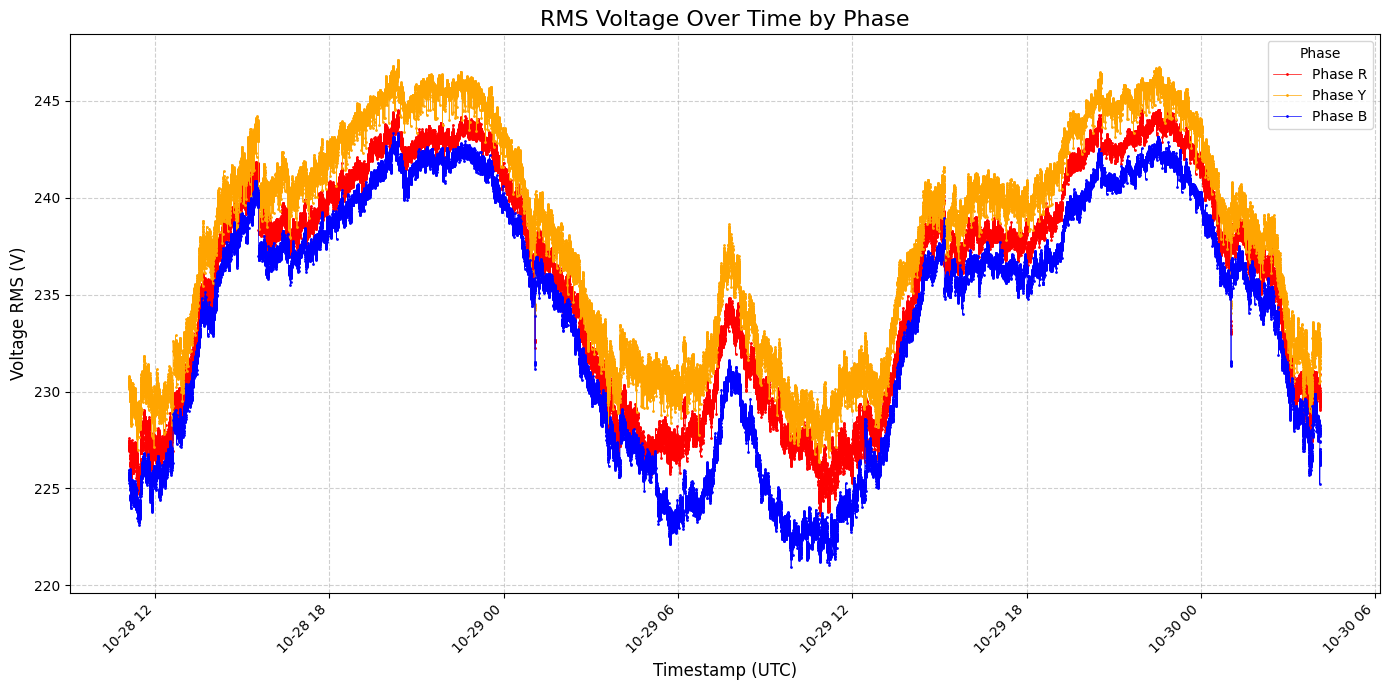

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILE_NAME = "first_100000_power_data.csv"

df = pd.read_csv(CSV_FILE_NAME)

df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

df_filtered = df[
    df['phase'].isin(['R', 'Y', 'B']) & 
    (df['voltage_rms'].notna()) & 
    (df['voltage_rms'] > 0)
].copy()

plt.figure(figsize=(14, 7))

phases = df_filtered['phase'].unique()
phase_colors = {'R': 'red', 'Y': 'orange', 'B': 'blue'} 

for phase in phases:
    phase_data = df_filtered[df_filtered['phase'] == phase]
    
    plt.plot(
        phase_data['timestamp'],
        phase_data['voltage_rms'],
        label=f'Phase {phase}',
        color=phase_colors.get(phase, 'gray'),
        marker='.',
        linestyle='-',
        markersize=2,
        linewidth=0.5
    )

plt.title('RMS Voltage Over Time by Phase', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Voltage RMS (V)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
plt.savefig('voltage_rms_vs_time_100k.png')

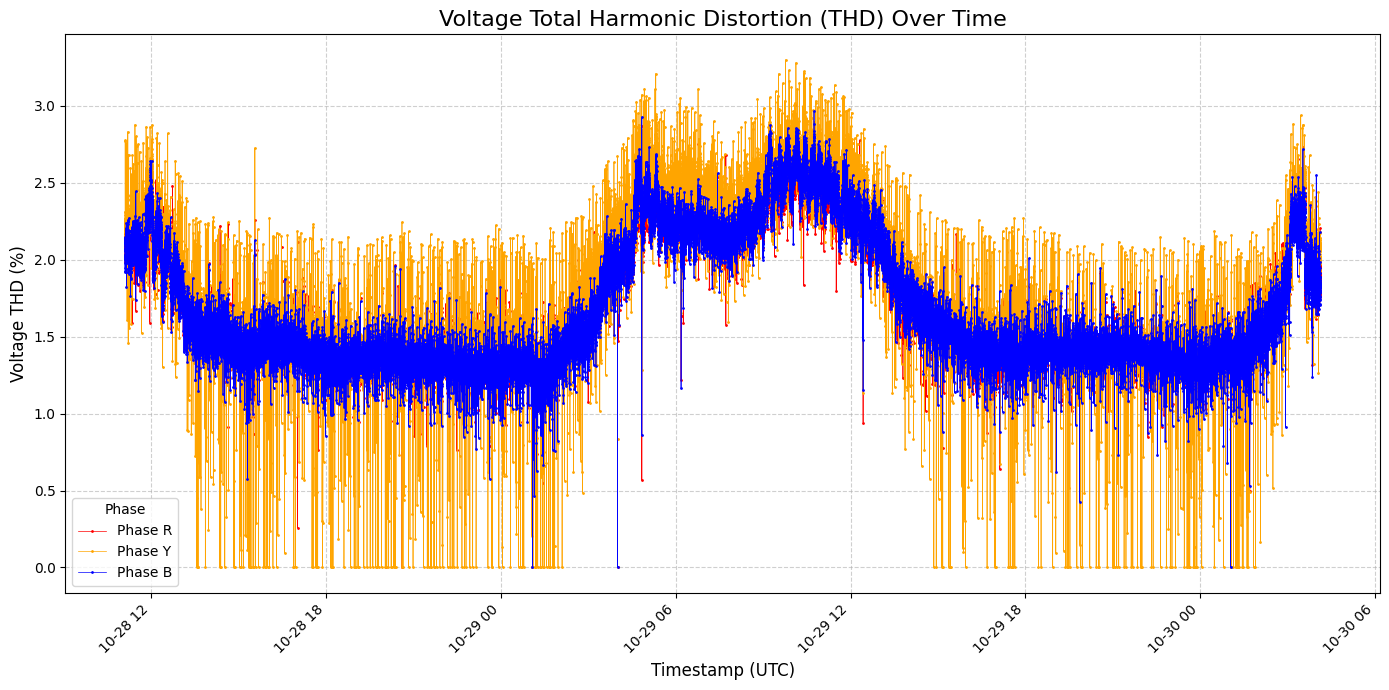

<Figure size 640x480 with 0 Axes>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILE_NAME = "first_100000_power_data.csv"
df = pd.read_csv(CSV_FILE_NAME)

df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# Filter for the main phases and drop rows where voltage_thd is missing
df_filtered = df[
    df['phase'].isin(['R', 'Y', 'B']) & 
    df['voltage_thd'].notna()
].copy()

plt.figure(figsize=(14, 7))

phases = df_filtered['phase'].unique()
phase_colors = {'R': 'red', 'Y': 'orange', 'B': 'blue'} 

for phase in phases:
    phase_data = df_filtered[df_filtered['phase'] == phase]
    
    plt.plot(
        phase_data['timestamp'],
        phase_data['voltage_thd'],
        label=f'Phase {phase}',
        color=phase_colors.get(phase, 'gray'),
        marker='.',
        linestyle='-',
        markersize=2,
        linewidth=0.5
    )

plt.title('Voltage Total Harmonic Distortion (THD) Over Time', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Voltage THD (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig('power_vs_time_100k.png')

In [14]:
import pandas as pd

CSV_FILE_NAME = "first_100000_power_data.csv"

df = pd.read_csv(CSV_FILE_NAME)

df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

df_filtered = df[
    df['phase'].isin(['R', 'Y', 'B']) & 
    (df['voltage_rms'].notna()) & 
    (df['voltage_rms'] > 0)
].copy()

summary_stats = df_filtered.groupby('phase')[
    ['voltage_rms', 'current_rms', 'active_power', 'power_factor']
].agg(['mean', 'std', 'min', 'max']).round(4)

total_energy = df_filtered['energy_kwh'].sum()

print("--- Descriptive Statistics by Phase ---")
print(summary_stats)
print("\n--- Total Energy Consumption ---")
print(f"Total Energy (kWH): {total_energy:.4f}")

--- Descriptive Statistics by Phase ---
      voltage_rms                             current_rms                 \
             mean     std       min       max        mean     std    min   
phase                                                                      
B        234.1688  6.2637  220.9258  243.3293      0.0574  0.1516  0.000   
R        236.0159  5.7709  223.6546  244.5587      0.1012  0.4186  0.037   
Y        238.2308  5.5899  226.3543  247.1280      0.0000  0.0000  0.000   

              active_power                             power_factor          \
          max         mean      std     min        max         mean     std   
phase                                                                         
B      0.4951      12.8105  33.8616  0.0000   112.1425       0.1233  0.3257   
R      5.4152      14.1275  92.2020  0.9617  1204.2899       0.1975  0.1025   
Y      0.0000       0.0096   0.0075  0.0000     0.0616       0.0000  0.0000   

                       
    

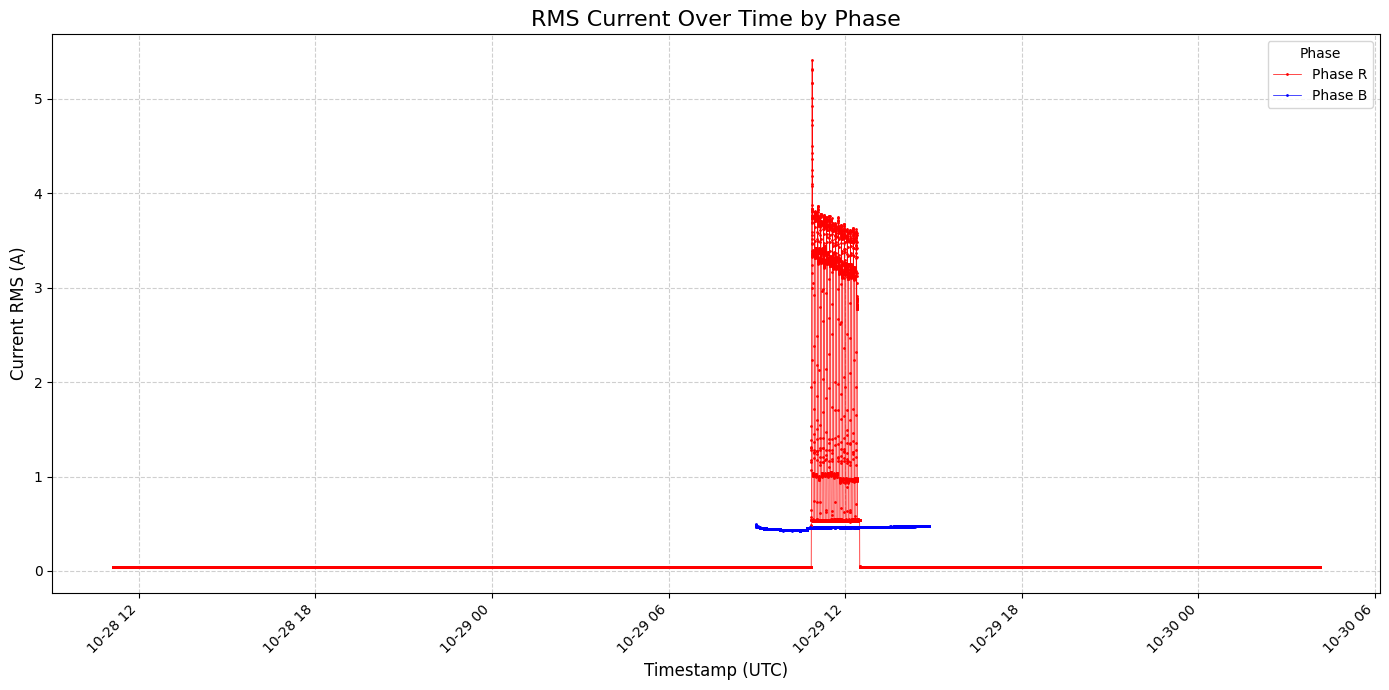

<Figure size 640x480 with 0 Axes>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILE_NAME = "first_100000_power_data.csv"

df = pd.read_csv(CSV_FILE_NAME)

df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

df_filtered = df[
    df['phase'].isin(['R', 'Y', 'B']) & 
    (df['current_rms'].notna()) & 
    (df['current_rms'] > 0)
].copy()

plt.figure(figsize=(14, 7))

phases = df_filtered['phase'].unique()
phase_colors = {'R': 'red', 'Y': 'orange', 'B': 'blue'} 

for phase in phases:
    phase_data = df_filtered[df_filtered['phase'] == phase]
    
    plt.plot(
        phase_data['timestamp'],
        phase_data['current_rms'],
        label=f'Phase {phase}',
        color=phase_colors.get(phase, 'gray'),
        marker='.',
        linestyle='-',
        markersize=2,
        linewidth=0.5
    )

plt.title('RMS Current Over Time by Phase', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Current RMS (A)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
plt.savefig('current_vs_time_100k.png')

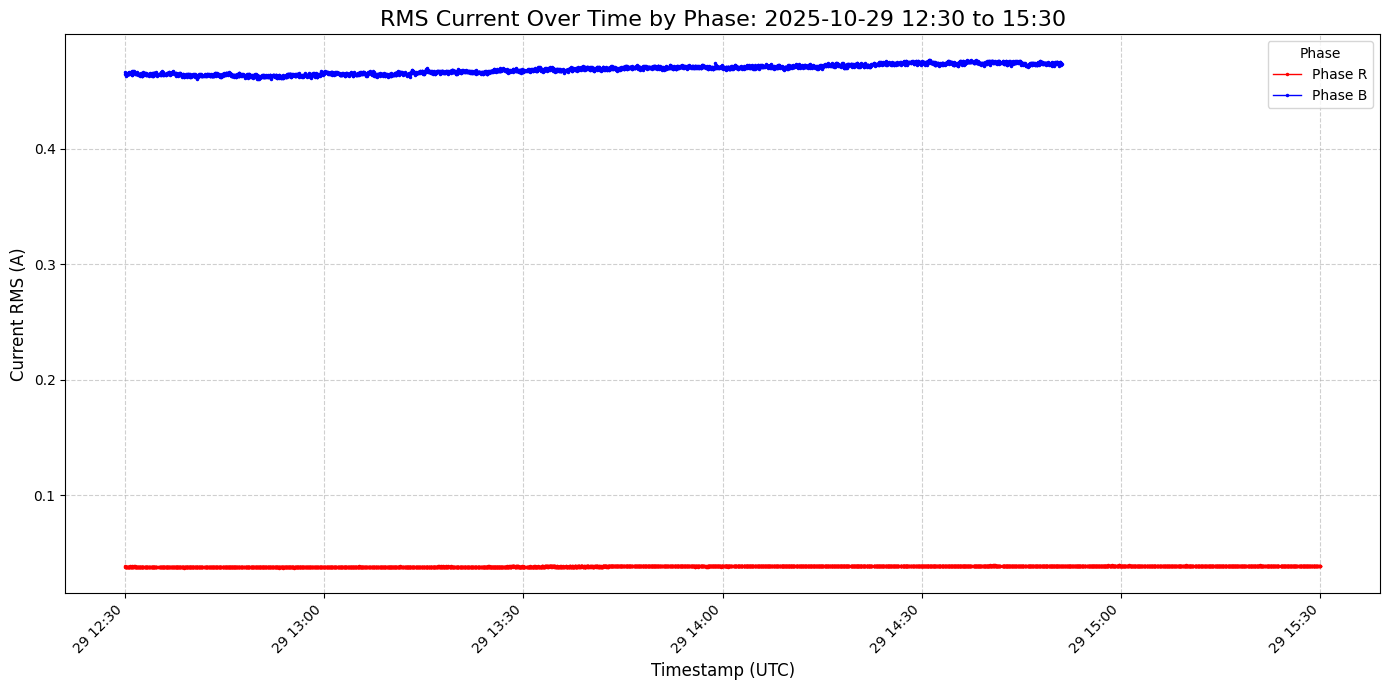

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILE_NAME = "first_100000_power_data.csv"

# 1. Read the CSV file
df = pd.read_csv(CSV_FILE_NAME)

# 2. Convert timestamp to datetime objects (essential for time-based filtering)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# 3. Define the specific time window for filtering
START_TIME = pd.to_datetime('2025-10-29 12:30:00', utc=True)
END_TIME = pd.to_datetime('2025-10-29 15:30:00', utc=True)

# 4. Filter data by:
#    a) Time range
#    b) Main phases (R, Y, B)
#    c) Non-zero current readings
df_filtered = df[
    (df['timestamp'] >= START_TIME) & (df['timestamp'] <= END_TIME) &
    df['phase'].isin(['R', 'Y', 'B']) & 
    (df['current_rms'].notna()) & 
    (df['current_rms'] > 0)
].copy()

# 5. Create the plot
plt.figure(figsize=(14, 7))

phases = df_filtered['phase'].unique()
phase_colors = {'R': 'red', 'Y': 'orange', 'B': 'blue'} 

for phase in phases:
    phase_data = df_filtered[df_filtered['phase'] == phase]
    
    plt.plot(
        phase_data['timestamp'],
        phase_data['current_rms'],
        label=f'Phase {phase}',
        color=phase_colors.get(phase, 'gray'),
        marker='.',
        linestyle='-',
        markersize=3,
        linewidth=1
    )

# 6. Format and display the plot
plt.title(f'RMS Current Over Time by Phase: 2025-10-29 {START_TIME.strftime("%H:%M")} to {END_TIME.strftime("%H:%M")}', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Current RMS (A)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

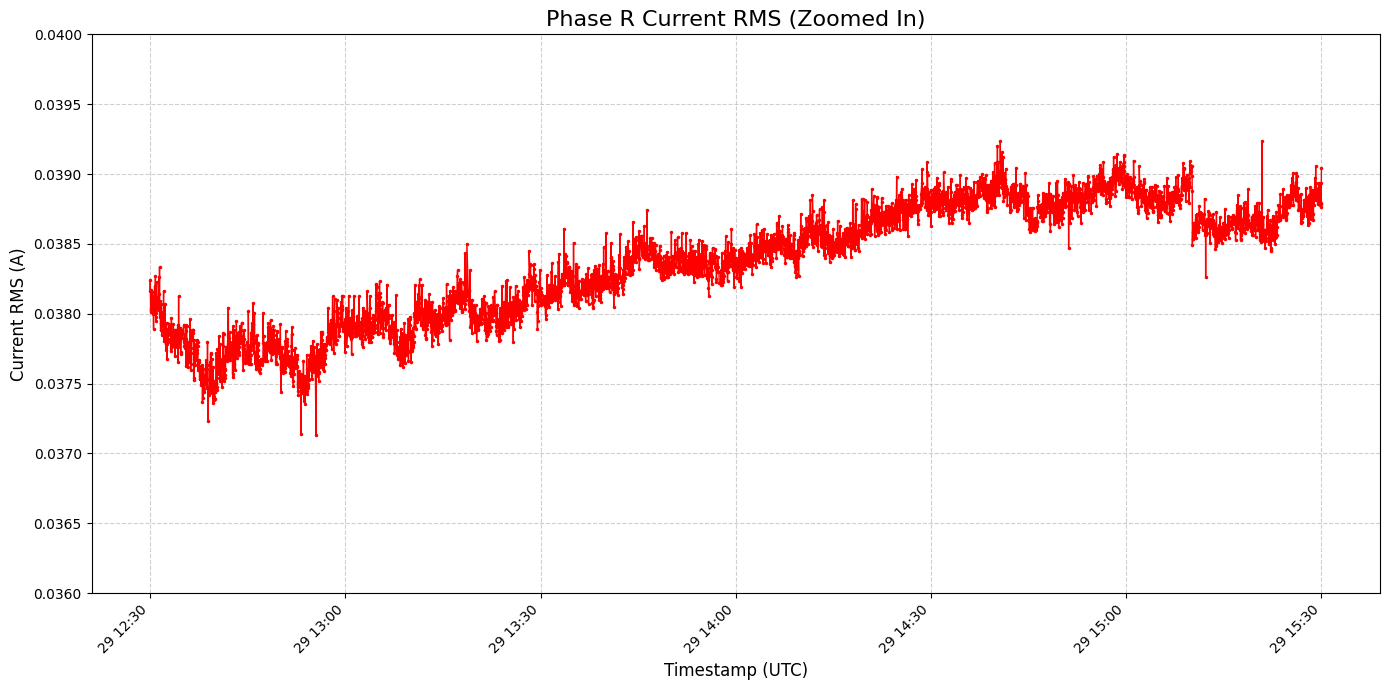

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILE_NAME = "first_100000_power_data.csv"

df = pd.read_csv(CSV_FILE_NAME)

df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# Define the specific time window (assuming 2025-10-29 12:30 to 15:30)
START_TIME = pd.to_datetime('2025-10-29 12:30:00', utc=True)
END_TIME = pd.to_datetime('2025-10-29 15:30:00', utc=True)

# Filter data for the time range and ONLY Phase R
df_phase_R = df[
    (df['timestamp'] >= START_TIME) & (df['timestamp'] <= END_TIME) &
    (df['phase'] == 'R') & 
    (df['current_rms'].notna())
].copy()

plt.figure(figsize=(14, 7))

plt.plot(
    df_phase_R['timestamp'],
    df_phase_R['current_rms'],
    label='Phase R Current',
    color='red',
    marker='.',
    linestyle='-',
    markersize=3,
    linewidth=1
)

# Crucial step: Limit the Y-axis to see small changes more clearly
plt.ylim(0.036, 0.04) 

plt.title('Phase R Current RMS (Zoomed In)', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Current RMS (A)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

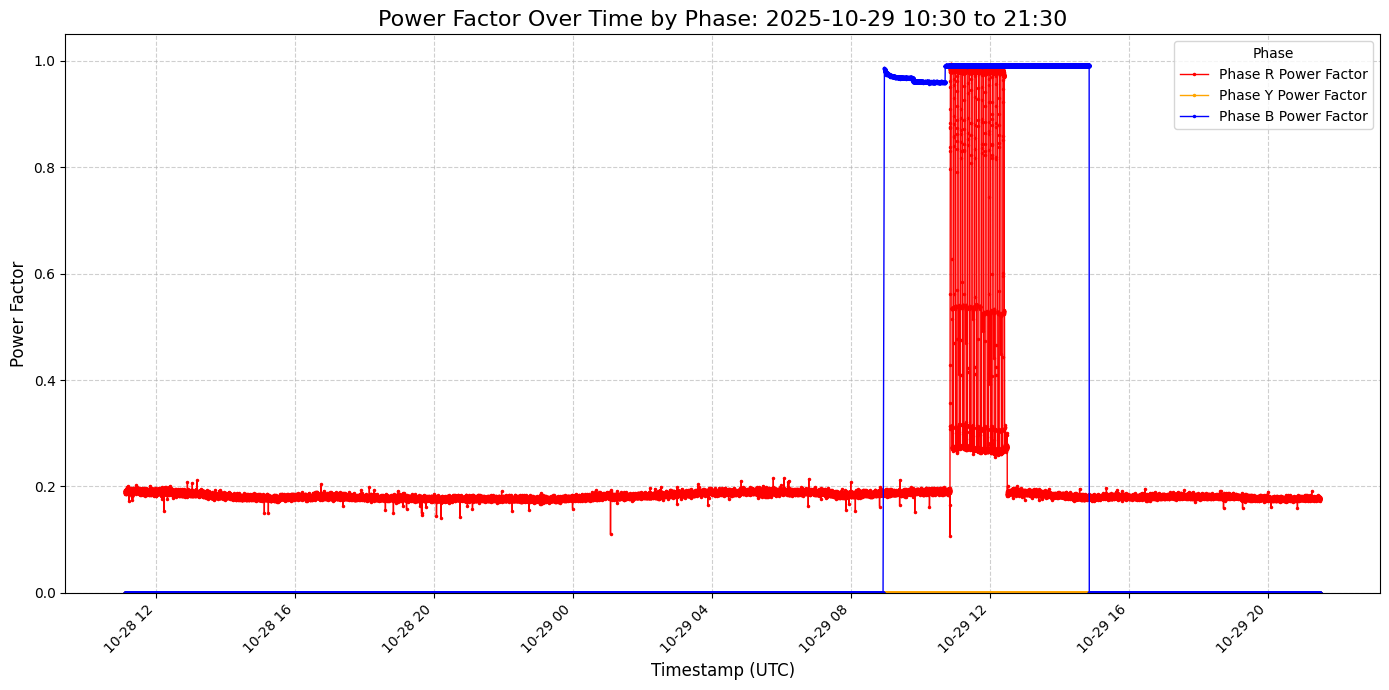

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILE_NAME = "first_100000_power_data.csv"

# 1. Read the CSV file
df = pd.read_csv(CSV_FILE_NAME)

# 2. Convert timestamp to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# 3. Define the specific time window
START_TIME = pd.to_datetime('2025-10-28 10:30:00', utc=True)
END_TIME = pd.to_datetime('2025-10-29 21:30:00', utc=True)

# 4. Filter data by time range and include ALL main phases (R, Y, B)
df_filtered = df[
    (df['timestamp'] >= START_TIME) & (df['timestamp'] <= END_TIME) &
    df['phase'].isin(['R', 'Y', 'B']) & 
    df['power_factor'].notna()
].copy()

# 5. Create the plot
plt.figure(figsize=(14, 7))

phases = df_filtered['phase'].unique()
# Standard colors for R, Y, B
phase_colors = {'R': 'red', 'Y': 'orange', 'B': 'blue'} 

for phase in phases:
    phase_data = df_filtered[df_filtered['phase'] == phase]
    
    plt.plot(
        phase_data['timestamp'],
        phase_data['power_factor'],
        label=f'Phase {phase} Power Factor',
        color=phase_colors.get(phase, 'gray'),
        marker='.',
        linestyle='-',
        markersize=3,
        linewidth=1
    )

# 6. Format and display the plot
plt.ylim(0.0, 1.05) # Power Factor is between 0 and 1, allowing for a 5% buffer
plt.title('Power Factor Over Time by Phase: 2025-10-29 10:30 to 21:30', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Power Factor', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

CSV_FILE_NAME = "first_100000_power_data.csv"

# Load and prepare data
df = pd.read_csv(CSV_FILE_NAME)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# Time window for focused analysis (2025-10-29 12:30 to 15:30)
START_TIME = pd.to_datetime('2025-10-29 12:30:00', utc=True)
END_TIME = pd.to_datetime('2025-10-29 15:30:00', utc=True)

# Filtered data for time series plots (R, Y, B phases with valid power data)
df_ts = df[
    df['phase'].isin(['R', 'Y', 'B']) & 
    df['active_power'].notna()
].copy()

# Filtered data for the specific 3-hour window
df_window = df_ts[
    (df_ts['timestamp'] >= START_TIME) & (df_ts['timestamp'] <= END_TIME)
].copy()

phases = df_ts['phase'].unique()
phase_colors = {'R': 'red', 'Y': 'orange', 'B': 'blue'} 


## 1. RMS Voltage Over Time (All Data)
plt.figure(figsize=(14, 7))
for phase in phases:
    phase_data = df_ts[df_ts['phase'] == phase]
    plt.plot(
        phase_data['timestamp'],
        phase_data['voltage_rms'],
        label=f'Phase {phase}',
        color=phase_colors.get(phase, 'gray'),
        marker='.',
        linestyle='-',
        markersize=2,
        linewidth=0.5
    )
plt.title('RMS Voltage Over Time by Phase (All Data)', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Voltage RMS (V)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('1_rms_voltage_all_data.png')
plt.close()


## 2. RMS Current Over Time (All Data)
plt.figure(figsize=(14, 7))
for phase in phases:
    phase_data = df_ts[df_ts['phase'] == phase]
    plt.plot(
        phase_data['timestamp'],
        phase_data['current_rms'],
        label=f'Phase {phase}',
        color=phase_colors.get(phase, 'gray'),
        marker='.',
        linestyle='-',
        markersize=2,
        linewidth=0.5
    )
plt.title('RMS Current Over Time by Phase (All Data)', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Current RMS (A)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('2_rms_current_all_data.png')
plt.close()


## 3. Combined Power and Distortion Plots (3-Hour Window)
plot_cols = ['current_thd', 'active_power', 'reactive_power', 'apparent_power']
plot_titles = ['Current Total Harmonic Distortion (THD)', 'Active Power (W)', 'Reactive Power (VAr)', 'Apparent Power (VA)']
plot_ylabels = ['Current THD (%)', 'Power (W)', 'Power (VAr)', 'Power (VA)']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 18), sharex=True)
fig.suptitle('Power Quality and Load Analysis by Phase (12:30 to 15:30)', fontsize=18, y=0.99)

for i, col in enumerate(plot_cols):
    ax = axes[i]
    for phase in phases:
        phase_data = df_window[df_window['phase'] == phase]
        ax.plot(
            phase_data['timestamp'],
            phase_data[col],
            label=f'Phase {phase}',
            color=phase_colors.get(phase, 'gray'),
            marker='.',
            linestyle='-',
            markersize=2,
            linewidth=0.5
        )
    ax.set_title(plot_titles[i], fontsize=14)
    ax.set_ylabel(plot_ylabels[i], fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title='Phase', loc='upper right')

axes[-1].set_xlabel('Timestamp (UTC)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('3_combined_power_plots_window.png')
plt.close()


## 4. Power Factor Over Time (3-Hour Window)
plt.figure(figsize=(14, 7))
for phase in phases:
    phase_data = df_window[df_window['phase'] == phase]
    plt.plot(
        phase_data['timestamp'],
        phase_data['power_factor'],
        label=f'Phase {phase} Power Factor',
        color=phase_colors.get(phase, 'gray'),
        marker='.',
        linestyle='-',
        markersize=3,
        linewidth=1
    )
plt.ylim(0.0, 1.05)
plt.title('Power Factor Over Time by Phase (12:30 to 15:30)', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Power Factor', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('4_power_factor_window.png')
plt.close()


## 5. Phase R Current RMS with Smoothing (Fan Search)
df_phase_R = df[
    (df['timestamp'] >= START_TIME) & (df['timestamp'] <= END_TIME) &
    (df['phase'] == 'R') & 
    (df['current_rms'].notna())
].copy()
df_phase_R['Current_Smoothed'] = df_phase_R['current_rms'].rolling(window=10).mean()

plt.figure(figsize=(14, 7))
plt.plot(
    df_phase_R['timestamp'],
    df_phase_R['Current_Smoothed'],
    label='Phase R Current (10-Point Rolling Mean)',
    color='blue',
    linewidth=2
)
plt.ylim(1.0, 2.0)
plt.title('Phase R Current RMS with Smoothing (12:30 to 15:30)', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Smoothed Current RMS (A)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('5_phase_R_current_smoothed.png')
plt.close()


## 6. Histogram of Power Factor (All Data)
df_hist = df_ts[df_ts['power_factor'].notna() & (df_ts['power_factor'] > 0)].copy()

plt.figure(figsize=(10, 6))
plt.hist(
    df_hist['power_factor'], 
    bins=50, 
    edgecolor='black', 
    alpha=0.7,
    color='teal'
)
plt.title('Distribution of Power Factor (All Data)', fontsize=16)
plt.xlabel('Power Factor (PF)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('6_power_factor_histogram.png')
plt.close()

print("All six plots have been generated and saved as PNG files in the current directory.")

All six plots have been generated and saved as PNG files in the current directory.


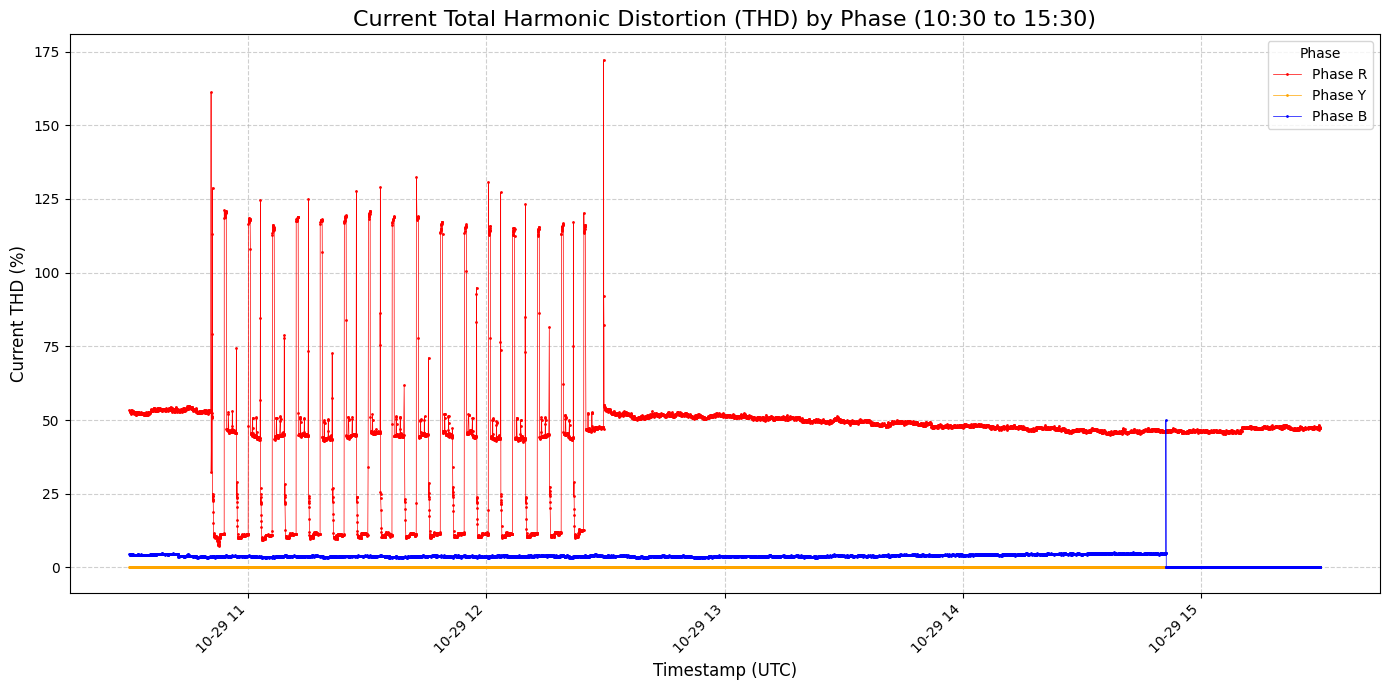

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILE_NAME = "first_100000_power_data.csv"

df = pd.read_csv(CSV_FILE_NAME)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

START_TIME = pd.to_datetime('2025-10-29 10:30:00', utc=True)
END_TIME = pd.to_datetime('2025-10-29 15:30:00', utc=True)

df_window = df[
    (df['timestamp'] >= START_TIME) & (df['timestamp'] <= END_TIME) &
    df['phase'].isin(['R', 'Y', 'B']) & 
    df['current_thd'].notna()
].copy()

phases = df_window['phase'].unique()
phase_colors = {'R': 'red', 'Y': 'orange', 'B': 'blue'} 

plt.figure(figsize=(14, 7))

for phase in phases:
    phase_data = df_window[df_window['phase'] == phase]
    
    plt.plot(
        phase_data['timestamp'],
        phase_data['current_thd'],
        label=f'Phase {phase}',
        color=phase_colors.get(phase, 'gray'),
        marker='.',
        linestyle='-',
        markersize=2,
        linewidth=0.5
    )

plt.title('Current Total Harmonic Distortion (THD) by Phase (10:30 to 15:30)', fontsize=16)
plt.xlabel('Timestamp (UTC)', fontsize=12)
plt.ylabel('Current THD (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('final_current_thd_plot.png')